In [ ]:
from selenium import webdriver
from time import sleep

skip = 0
player_lst = []
for i in range(10):
    url = f"https://api.tracker.gg/api/v1/valorant/standard/leaderboards?type=ranked&platform=pc&board=default&region=global&act=16118998-4705-5813-86dd-0292a2439d90&skip={skip}&take=100"

    driver_path = "/Users/kahunghe/Documents/GitHub/GE2324_GP9/chromedriver"
    driver = webdriver.Chrome(executable_path=driver_path)
    driver.get(url)
    skip += 100
    df = eval(driver.page_source.replace("""</pre><div class="json-formatter-container"></div></body></html>""","").replace("""<html><head><meta name="color-scheme" content="light dark"><meta charset="utf-8"></head><body><pre>""","").replace('null','None').replace('false','False').replace('true','True'))
    for i in df_pos_pos_pos_pos['data']['items']:
        player_lst.append(i['id'])
    sleep(10)
driver.quit()

with open('players.txt','w') as f:
    f.write(str(player_lst))

print(player_lst)

In [ ]:
len(player_lst)

In [ ]:

from random import randint
for player in player_lst[3:20]:
    try:
        #from player get all match id
        player = player.replace('#','%23')
        pages = 0

        match_id_lst = []
        for i in range(30):
            url = f"https://api.tracker.gg/api/v2/valorant/standard/matches/riot/{player}?type=competitive&season=&agent=all&map=all&next={pages}"

            driver_path = "/Users/kahunghe/Documents/GitHub/GE2324_GP9/chromedriver"
            driver = webdriver.Chrome(executable_path=driver_path)
            driver.get(url)
            pages+=1
            df = eval(driver.page_source.replace("""</pre><div class="json-formatter-container"></div></body></html>""","").replace("""<html><head><meta name="color-scheme" content="light dark"><meta charset="utf-8"></head><body><pre>""","").replace('null','None').replace('false','False').replace('true','True'))
            for j in df['data']['matches']:
                round_data = j['segments'][0]['stats']
                round_data_processed = {}
                for k in round_data:
                    round_data_processed = round_data_processed | {k:round_data[k]['value']}

                match_id_lst.append({"id":j['attributes']['id'],"map":j['attributes']['mapId']} |
                                    {'result':j['segments'][0]['metadata']['result']} |
                                    round_data_processed)
            
            

            sleep(randint(60,120))
        driver.quit()

        print(len(match_id_lst))
        #save to txt
        with open(f'matches/{player}_match_id.txt','w') as f:
            f.write(str(match_id_lst))
    except Exception as e:
        print(f"Error: {player}", e)
        sleep(120)
        continue

    


In [ ]:
with open('matches/kupecc%23111_match_id.txt','r') as f:
    match_id_lst = eval(f.read())
match_id_lst

In [ ]:
map_set = set([i['map'] for i in match_id_lst])
map_set
    

In [ ]:
# get all match history


import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import json
import pandas as pd


for player_match in match_data:
    try:
        for match in player_match:
            match_id = match['id']
            match_url = f"https://api.tracker.gg/api/v2/valorant/standard/matches/{match_id}"

            driver_path = "/Users/kahunghe/Documents/GitHub/GE2324_GP9/chromedriver"
            driver = webdriver.Chrome(executable_path=driver_path)
            driver.get(match_url)    
            sleep(randint(60,120))
            #to dict
            match_test_df = json.loads(driver.page_source.replace("""</pre><div class="json-formatter-container"></div></body></html>""","").replace("""<html><head><meta name="color-scheme" content="light dark"><meta charset="utf-8"></head><body><pre>""",""))

            driver.quit()
            with open(f'match_data/{match_id}.txt','w') as f:
                f.write(str(match_test_df))
    except Exception as e:
        print(f"Error: {match['id']}", e)
        sleep(120)
        continue


    # segments = []
    # target_map = [i['id'] for i in match_id_lst if i['map'] == '/Game/Maps/Ascent/Ascent']
    # print(len(target_map))
    # for match_id in target_map:

    #     match_url = f"https://api.tracker.gg/api/v2/valorant/standard/matches/{match_id}"

    #     driver_path = "/Users/kahunghe/Documents/GitHub/GE2324_GP9/chromedriver"
    #     driver = webdriver.Chrome(executable_path=driver_path)
    #     driver.get(match_url)    
    #     sleep(5)
    #     #to dict
    #     match_test_df = json.loads(driver.page_source.replace("""</pre><div class="json-formatter-container"></div></body></html>""","").replace("""<html><head><meta name="color-scheme" content="light dark"><meta charset="utf-8"></head><body><pre>""",""))

    #     driver.quit()
        
    #     segments += match_test_df["data"]["segments"]








In [19]:
#load all match data
import pandas as pd
match_data = []
#open all text file in matches folder
import os
for file in os.listdir('match_data'):
    try:
        with open(f'match_data/{file}','r') as f:
            match_data.append(eval(f.read()))
    except:
        print(file)
        continue

match_data


#####too slow！！


.DS_Store


KeyboardInterrupt: 

In [20]:
#multi threading reading
import concurrent.futures
import time
import os

def read_file(file):
    with open(f'match_data/{file}','r') as f:
        return eval(f.read())
    
start = time.time()
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(read_file, os.listdir('match_data'))


match_data = list(results)





In [26]:
import math
import random
import pandas as pd
import requests
from PIL import Image
from io import BytesIO

features = []  # 存储特征：[x, y, sin(viewRadians), cos(viewRadians)]
labels = []    # 标签，每个标签为 [kill_label, killed_label]

# 先获取 Abyss 地图的图片及转换参数（只取第一个匹配的）
for match in match_data:
    if match['data']['metadata']['mapName'] == 'Abyss':
        map_img_url = match["data"]["metadata"]['mapDetails']['imageUrl']
        response = requests.get(map_img_url)
        with open('Abyss.png', 'wb') as f:
            f.write(response.content)
        image = Image.open(BytesIO(response.content))
        image_width, image_height = image.size
        # 获取地图转换参数（假设同一地图下所有 match 的参数一致）
        xMultiplier = match["data"]["metadata"]['mapDetails']['xMultiplier']
        yMultiplier = match["data"]["metadata"]['mapDetails']['yMultiplier']
        xScalarToAdd = match["data"]["metadata"]['mapDetails']['xScalarToAdd']
        yScalarToAdd = match["data"]["metadata"]['mapDetails']['yScalarToAdd']
        break

# 遍历所有 Abyss 地图的 match
for match in match_data:
    if match['data']['metadata']['mapName'] != 'Abyss':
        continue

    # 读取转换参数（假设同一地图参数一致）
    xMultiplier = match["data"]["metadata"]['mapDetails']['xMultiplier']
    yMultiplier = match["data"]["metadata"]['mapDetails']['yMultiplier']
    xScalarToAdd = match["data"]["metadata"]['mapDetails']['xScalarToAdd']
    yScalarToAdd = match["data"]["metadata"]['mapDetails']['yScalarToAdd']

    for record in match['data']['segments']:
        if record['type'] == 'player-round-kills':
            killer_id = record["attributes"]["platformUserIdentifier"]
            metadata = record["metadata"]
            player_locations = metadata.get("playerLocations", [])

            # 收集非 killer 的记录作为负样本候选，并同时寻找击杀者的信息
            candidate_negatives = []
            killer_info = None
            for p in player_locations:
                if p.get("platformUserIdentifier") == killer_id:
                    killer_info = p
                else:
                    candidate_negatives.append(p)

            # 1. 击杀样本：使用击杀者（killer）的位置和视角，标签为 [1, 0]
            if killer_info is not None:
                loc = killer_info.get("location", {})
                viewRadians = killer_info.get("viewRadians")
                if loc and viewRadians is not None:
                    sin_view = math.sin(viewRadians)
                    cos_view = math.cos(viewRadians)
                    # 坐标转换（这里按原代码进行转换，注意 x 与 y 的对应关系）
                    feature_x = (loc.get("y") * xMultiplier + xScalarToAdd) * image_height
                    feature_y = (loc.get("x") * yMultiplier + yScalarToAdd) * image_width
                    features.append([feature_x, feature_y, sin_view, cos_view])
                    labels.append([1, 0])
            
            # 2. 被击杀样本：使用对手位置（victim，存储在 metadata["opponentLocation"]），标签为 [0, 1]
            # 此处计算受害者的朝向：受害者应面向击杀者，即朝向从 victim 到 killer 的方向
            victim_loc = metadata.get("opponentLocation", {})
            if victim_loc and killer_info is not None:
                # 转换受害者的坐标
                victim_feature_x = (victim_loc.get("y") * xMultiplier + xScalarToAdd) * image_height
                victim_feature_y = (victim_loc.get("x") * yMultiplier + yScalarToAdd) * image_width
                # 同时转换击杀者的坐标
                killer_loc = killer_info.get("location", {})
                killer_feature_x = (killer_loc.get("y") * xMultiplier + xScalarToAdd) * image_height
                killer_feature_y = (killer_loc.get("x") * yMultiplier + yScalarToAdd) * image_width
                # 计算角度：从受害者指向击杀者
                angle = math.atan2(killer_feature_y - victim_feature_y, killer_feature_x - victim_feature_x)
                sin_view = math.sin(angle)
                cos_view = math.cos(angle)
                features.append([victim_feature_x, victim_feature_y, sin_view, cos_view])
                labels.append([0, 1])
            
            # 3. 负样本：随机采样一个非击杀者的位置，标签为 [0, 0]
            if candidate_negatives:
                neg_sample = random.choice(candidate_negatives)
                loc = neg_sample.get("location", {})
                viewRadians = neg_sample.get("viewRadians")
                if loc and viewRadians is not None:
                    sin_view = math.sin(viewRadians)
                    cos_view = math.cos(viewRadians)
                    feature_x = (loc.get("y") * xMultiplier + xScalarToAdd) * image_height
                    feature_y = (loc.get("x") * yMultiplier + yScalarToAdd) * image_width
                    features.append([feature_x, feature_y, sin_view, cos_view])
                    labels.append([0, 0])

# 构造 DataFrame，并增加两列标签：kill_label 和 killed_label
df = pd.DataFrame(features, columns=['x', 'y', 'sin_view', 'cos_view'])
df['kill_label'] = [lbl[0] for lbl in labels]
df['killed_label'] = [lbl[1] for lbl in labels]

# 过滤掉超出地图范围的点（假设地图坐标范围为 x: [0, image_width], y: [0, image_height]）
filtered_df = df[(df['x'] >= 0) & (df['x'] <= image_width) &
                 (df['y'] >= 0) & (df['y'] <= image_height)]

# 保存为 CSV 文件
filtered_df.to_csv("game_data_with_negatives.csv", index=False)
print("CSV 文件已保存为 game_data_with_negatives.csv")


CSV 文件已保存为 game_data_with_negatives.csv


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import kerastuner as kt
import joblib  # 用于加载 scaler
# 1. 读取数据
df = pd.read_csv("game_data_with_negatives.csv")
# 假设 CSV 中有 4 个特征：x, y, sin_view, cos_view
# 标签为两列：kill_label 和 killed_label
X = df[['x', 'y', 'sin_view', 'cos_view']].values
y = df[['kill_label', 'killed_label']].values

# 2. 特征归一化（可根据实际情况调整，确保测试时一致）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler.pkl')
# 模型输入为 (samples, 4, 1)，故 reshape 数据
X_scaled = X_scaled.reshape(-1, 4, 1)

# 3. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. 定义模型构建函数（使用超参数调优）
def build_model(hp):
    model = keras.Sequential()
    # 第一层 Conv1D，调优 filters 和 kernel_size
    model.add(layers.Conv1D(
        filters=hp.Int('filters', min_value=8, max_value=64, step=8),
        kernel_size=hp.Choice('kernel_size', values=[2, 3]),
        activation='relu',
        input_shape=(4, 1)
    ))
    # 展平层
    model.add(layers.Flatten())
    # 全连接层，调优 units
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=8, max_value=32, step=8),
        activation='relu'
    ))
    # Dropout 层，调优 dropout 比例
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    # 输出层：2 个神经元，用 sigmoid 激活（每个输出独立预测概率）#77.95 in soft max
    model.add(layers.Dense(2, activation='sigmoid'))
    
    # 调优学习率
    optimizer = keras.optimizers.Adam(
        hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    )
    # 采用 binary_crossentropy 作为多标签（多输出独立概率）的损失函数
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# 5. 使用 Keras Tuner 进行超参数调优
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='cnn_hyperparameter_tuning_multilabel'
)

# 添加 early stopping 回调
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# 开始超参数搜索
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[stop_early])

# 获取最佳超参数
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("最佳超参数:")
print(best_hps.values)

# 6. 构建最终模型并训练
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[stop_early])
model.save("best_model.keras")
# 7. 在测试集上评估模型
test_loss, test_acc = model.evaluate(X_test, y_test)
print("测试集准确率: {:.2f}%".format(test_acc * 100))

# 8. 输出部分预测结果
y_pred = model.predict(X_test)
print(X_test)
# 将预测概率转为 0/1 (阈值设定为 0.5)
y_pred_labels = (y_pred > 0.5).astype(int)
print("部分预测结果:")
print(y_pred_labels[:10])


Trial 30 Complete [00h 01m 29s]
val_accuracy: 0.6381393074989319

Best val_accuracy So Far: 0.6843666434288025
Total elapsed time: 00h 35m 07s
最佳超参数:
{'filters': 32, 'kernel_size': 3, 'dense_units': 16, 'dropout': 0.1, 'learning_rate': 0.001601348848498851, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0022'}
Epoch 1/20
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.5835 - loss: 0.6358 - val_accuracy: 0.6009 - val_loss: 0.6153
Epoch 2/20
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.6070 - loss: 0.6186 - val_accuracy: 0.6161 - val_loss: 0.6187
Epoch 3/20
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.5531 - loss: 0.6413 - val_accuracy: 0.4864 - val_loss: 0.6260
Epoch 4/20
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.5250 - loss: 0.6522 - val_accuracy: 0.4866 - val_loss: 0.6618
Epoch 5/20
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.5173 - loss: 0.6688 - val_accuracy: 0.5

In [2]:
import tensorflow as tf
import numpy as np
model = tf.keras.models.load_model("best_model.keras")
raw_feature = np.array([-1.47571192, -0.70386898, -0.65683017, -1.25153307]).reshape(1, -1)
feature = raw_feature.reshape(1,4,1)
print(feature)
prediction = model.predict(feature)
print(prediction)

[[[-1.47571192]
  [-0.70386898]
  [-0.65683017]
  [-1.25153307]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[1.000000e+00 6.072366e-09]]


             x            y  sin_view  cos_view  label
0   537.284608   257.763328  0.999201  0.039969      1
1   912.855040   469.436416  0.996430 -0.084428      0
2  1098.483712    49.076224  0.131825 -0.991273      1
3  1284.775936   299.898880 -0.912689  0.408655      0
4   699.523072  1085.378560  0.999515  0.031154      1


/Users/kahunghe/Documents/GitHub/GE2324_GP9/tf_keras/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kahunghe/Documents/GitHub/GE2324_GP9/tf_keras/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kahunghe/Documents/GitHub/GE2324_GP9/tf_keras/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kahunghe/Documents/GitHub/GE2324_GP9/tf_keras/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/k

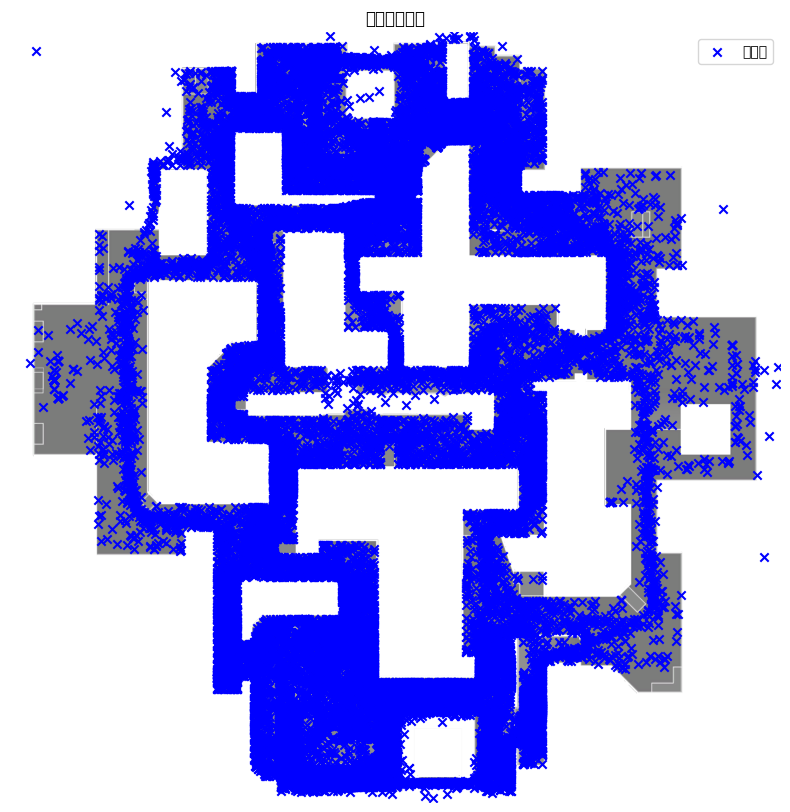

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# 1. 读取 CSV 数据
df = pd.read_csv("game_data_with_negatives.csv")
# 查看数据前几行
print(df.head())

# 2. 读取地图图片（请确保图片文件存在且路径正确）
map_img = Image.open("Abyss.png")

# 3. 绘制地图和点的位置
plt.figure(figsize=(10, 10))

# 显示地图作为背景（设置 origin='upper' 使得坐标原点与图片左上角对应，
# 根据实际情况可调整 origin 参数）
plt.imshow(map_img)

# 分别提取正样本（label == 1）和负样本（label == 0）
positive = df[df['label'] == 1]
negative = df[df['label'] == 0]

# 在地图上绘制正样本点（红色）和负样本点（蓝色）
#plt.scatter(positive['x'], positive['y'], c='red', marker='o', label='正样本')
plt.scatter(negative['x'], negative['y'], c='blue', marker='x', label='负样本')

plt.title("地图与点位置")
plt.legend()
plt.axis('off')  # 隐藏坐标轴
plt.show()


In [17]:
    # plt.figure(figsize=(15, 15))

    # plt.imshow(image)

    # #add 4 corners,for better image
    # points.append((0,0))
    # points_killer.append((0,0))
    # points.append((image_width,image_height))
    # points_killer.append((image_width,image_height))
    # points.append((0,image_height))
    # points_killer.append((0,image_height))
    # points.append((image_width,0))
    # points_killer.append((image_width,0))


    # if len(points) > 0:
    #     sns.kdeplot(
    #         x=[i[0] for i in points], y=[i[1] for i in points], 
    #         cmap="Reds", fill=True, alpha=0.4, thresh=0,bw_method = 0.1
    #     )

    # if len(points_killer) > 0:
    #     sns.kdeplot(
    #         x=[i[0] for i in points_killer], y=[i[1] for i in points_killer], 
    #         cmap="Greens", fill=True, alpha=0.4, thresh=0,bw_method = 0.1
    #     )


    # plt.scatter(*zip(*points), color='red', s=5, marker='x', alpha=0.3)
    # plt.scatter(*zip(*points_killer), color='green', s=5, marker='x', alpha=0.3)
    # plt.axis("off")
    # plt.savefig(f"images/{match['data']['metadata']['mapName']}_{match['data']['attributes']['id']}.png",bbox_inches='tight', pad_inches=0)
    # #plt.show()




In [18]:
df_pos.to_csv('pos_data.csv')

In [ ]:
# 假设您有新的数据需要预测
new_data = np.array([[0, 0.1, 0.2]])  # 示例数据，'map'为0，'x'和'y'是标准化后的坐标
prediction = model.predict(new_data)

# 输出预测的类别及其概率
predicted_class = np.argmax(prediction)  # 预测类别
predicted_prob = prediction[0][predicted_class]  # 预测概率

print(f"Predicted State: {predicted_class}")
print(f"Probability: {predicted_prob}")


In [11]:
#load player data to df
import pandas as pd
import os

matches = []
for file in os.listdir('matches'):
    with open(f'matches/{file}','r') as f:
        m = eval(f.read())
        for i in m:
            i['player'] = file.replace('_match_id.txt','')
            #match agent
            

            matches.append(i)

        



In [17]:
df = pd.DataFrame(matches)

df.to_csv('matches.csv',index=False)



In [ ]:
df.columns

In [ ]:
#corrlations
import seaborn as sns
import matplotlib.pyplot as plt

#drop all non numeric columns
df_normalized = df.drop(['kasted','antiEco','totalThrifty','totalAntiEco','manAdvantage','manDisadvantage','rank'],axis=1)
#fill 0 to nan
df_normalized = df_normalized.fillna(0)
#Percentage to decimal
df_normalized['headshotsPercentage'] = df_normalized['headshotsPercentage']/100

#take map to temp df
df_temp = df_normalized[['map','player','id','result']]
#drop map
df_normalized = df_normalized.drop(['map'],axis=1)
#drop id
df_normalized = df_normalized.drop(['id'],axis=1)
#drop player
df_normalized = df_normalized.drop(['player'],axis=1)
#drop result
df_normalized = df_normalized.drop(['result'],axis=1)
#normalize 
df_normalized = (df_normalized - df_normalized.mean()) / df_normalized.std()
#map to number
map_dict = {'/Game/Maps/Canyon/Canyon':1,
            '/Game/Maps/Pitt/Pitt':2,
            '/Game/Maps/Bonsai/Bonsai':3,
            '/Game/Maps/Port/Port':4,
            '/Game/Maps/Jam/Jam':5,
            '/Game/Maps/Triad/Triad':6,
            '/Game/Maps/Ascent/Ascent':7,
            '/Game/Maps/Duality/Duality':8,
            '/Game/Maps/Infinity/Infinity':9,
            '/Game/Maps/Juliett/Juliett':10,
            '/Game/Maps/Foxtrot/Foxtrot':11,}

df_normalized['map'] = df_temp['map'].map(map_dict)
#change result -1 for loss, 1 for win 0 for tie
df_normalized['result'] = df_temp['result']#.apply(lambda x: 1 if x == 'victory' else -1 if x == 'defeat' else 0)
df_normalized['player'] = df_temp['player']
df_normalized['id'] = df_temp['id']

#heatmap
plt.figure(figsize=(10,10))
#trun off number in the heatmap
df_corr = df_normalized.drop(['id'],axis=1)
sns.heatmap(df_corr.corr(),annot=False)

plt.show()


In [ ]:
df_normalized.columns

In [ ]:
plt.figure(figsize=(10,10))
#normalize the data

sns.heatmap(df_corr.corr()[['deaths']],annot=True)


In [ ]:
#distribution
df.hist(figsize=(20,20))
plt.show()
